## MATH 497: Intro to Machine Learning Midterm
### Jenny Fothergill

Let y be defined as
$$y = a \exp\bigg(-\sum_{i=1}^{p}{x_{i}b_{i}}\bigg)+ \epsilon$$
where $x$ and $b$ are arrays

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with np.load("Fothergill_Midterm_Data.npz") as data:
    # for key in data.keys():
    #    print(key)
    xTrain, yTrain = data["xTrain"], data["yTrain"]
    xVal, yVal = data["xVal"], data["yVal"]

print(f"xTrain shape {xTrain.shape}")
print(f"yTrain shape {yTrain.shape}")
print(f"xVal shape {xVal.shape}")
print(f"yVal shape {yVal.shape}")

xTrain shape (80, 6)
yTrain shape (80,)
xVal shape (20, 6)
yVal shape (20,)


In [2]:
# function to fit
def f(a, b, x):
    return a * np.exp(-b.dot(x.T))

final a : 1.5470321995934244
final b : [[0.73234886 1.41472086 0.11973016 1.0284934  0.38338442 0.11861487]]


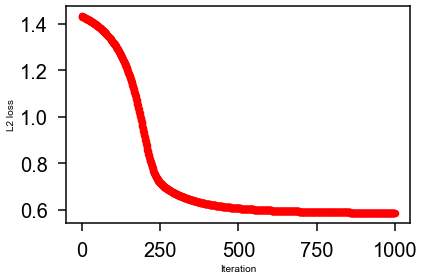

In [3]:
# Numpy gradient descent

# pick initial values
a = 1
b = np.ones((1, xTrain.shape[1]), dtype="float64")
# b is (1x6)

iterations = 1000
# learning rate
lr = 0.01
losses = []

for t in range(iterations):
    ypred = f(a, b, xTrain)
    # ypred is (1x80), yTrain is (80,)

    # L2 loss
    loss = np.sum((ypred - yTrain) ** 2)
    losses.append(loss)

    # We want to find the change in loss wrt a and b
    # so we have to do the partials (see markdown cell below)
    dL_dypred = 2 * (ypred - yTrain)
    # dL_dypred is (1x80)

    dypred_da = np.exp(-b.dot(xTrain.T))
    # dypred_da is (1x80)

    dypred_db = -xTrain * ypred.T
    # dypred_db is (80x6)

    dL_da = np.dot(dL_dypred, dypred_da.T)
    # dL_da (1x1)

    dL_db = np.dot(dL_dypred, dypred_db)
    # dL_db (1x6)

    # gradient descent
    a -= lr * dL_da[0][0]
    b -= lr * dL_db

print(f"final a : {a}")
print(f"final b : {b}")

plt.plot(losses, "ro")
plt.xlabel("Iteration")
plt.ylabel("L2 loss")
plt.show()

# Partial derivitives

$$L = \sum{(ypred-y)^{2}}$$

$$ypred = ae^{-bx}$$

$$\frac{d L}{d a} =\frac{\delta L}{\delta ypred} \cdot \frac{\delta ypred}{\delta a}$$

$$\frac{d L}{d b} =\frac{\delta L}{\delta ypred} \cdot \frac{\delta ypred}{\delta b}$$

$$\frac{\delta L}{\delta ypred} = 2 \cdot (ypred - y)^{2}$$

$$\frac{\delta ypred}{\delta a} = e^{-bx}$$

$$\frac{\delta ypred}{\delta b} = -x \cdot ae^{-bx} = -x \cdot ypred$$

a : 1.547
b : [[0.73234886 1.41472086 0.11973016 1.0284934  0.38338442 0.11861487]]


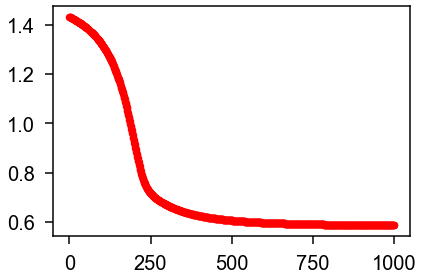

In [73]:
import torch

# initial values
at = torch.DoubleTensor([1])
bt = torch.from_numpy(np.ones((1, xTrain.shape[1]), dtype="float64"))
# at (1), bt (1x6)

at.requires_grad_(True)
bt.requires_grad_(True)

xt = torch.from_numpy(xTrain)
yt = torch.from_numpy(yTrain)
# xt (80x6), yt (80)

iterations = 1000
# learning rate
lr = 0.01
losses = []

for t in range(iterations):
    ypred = at * torch.exp(-bt.matmul(xt.T))
    # (1x6)dot(6x80) is (1x80)

    # L2
    error = yt - ypred
    loss = (error ** 2).sum()

    losses.append(loss)

    loss.backward()

    # we want to keep the update out of the gradient calculation
    # this will prevent
    # "RuntimeError: a leaf Variable that requires grad has been
    # used in an in-place operation."
    with torch.no_grad():
        at -= lr * at.grad
        bt -= lr * bt.grad

    # reset gradient
    at.grad.zero_()
    bt.grad.zero_()

at_final = at.data.numpy()[0]
bt_final = bt.data.numpy()
print(f"a : {at_final:.3f}")
print(f"b : {bt_final}")

plt.plot(losses, "ro")
plt.show()

In [62]:
# Now let's tune the learning rate in Numpy

iterations = 1000
# learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.09, 0.10, 0.11, 0.15, 0.2, 0.3]
losses = {}
lr_loss = np.zeros((len(lrs), 2), dtype="float64")
abvals = {}

for i, lr in enumerate(lrs):
    losses[lr] = []
    
    # pick initial values
    a = 1
    b = np.ones((1, xTrain.shape[1]), dtype="float64")
    # b is (1x6)
    
    for t in range(iterations):
        ypred = f(a, b, xTrain)
        # ypred is (1x80), yTrain is (80,)

        # L2 loss
        loss = np.sum((ypred - yTrain) ** 2)
        losses[lr].append(loss)

        # We want to find the change in loss wrt a and b
        # so we have to do the partials (see markdown cell below)
        dL_dypred = 2 * (ypred - yTrain)
        # dL_dypred is (1x80)

        dypred_da = np.exp(-b.dot(xTrain.T))
        # dypred_da is (1x80)

        dypred_db = -xTrain * ypred.T
        # dypred_db is (80x6)

        dL_da = np.dot(dL_dypred, dypred_da.T)
        # dL_da (1x1)

        dL_db = np.dot(dL_dypred, dypred_db)
        # dL_db (1x6)

        # gradient descent
        a -= lr * dL_da[0][0]
        b -= lr * dL_db

    # save the final loss value to the array
    lr_loss[i, :] = [lr, loss]
    
    abvals[lr] = (a, b)

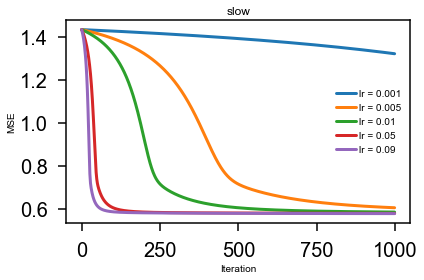

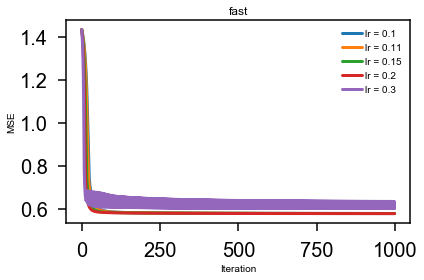

In [63]:
fast_lrs = [i for i in lrs[len(lrs)//2:]]
slow_lrs = [i for i in lrs[:len(lrs)//2]]

for lr in slow_lrs:
    plt.plot(losses[lr], label=f"lr = {lr}")
plt.title("slow")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()  

for lr in fast_lrs:
    plt.plot(losses[lr], label=f"lr = {lr}")
plt.title("fast")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()  

In [64]:
# Numpy
min_array = lr_loss[np.where(lr_loss == np.min(lr_loss[:, 1]))[0], :]
print("learning rate | final loss")
print(min_array)
# If you go higher than 0.2 with the learning rate, the algorithm starts 
# to blow up. Potentially this is because the loss gets small enough that 
# we're getting into numerical overflow?

learning rate | final loss
[[0.2       0.5784551]]


In [61]:
# Learning rate optimization in pytorch

xt = torch.from_numpy(xTrain)
yt = torch.from_numpy(yTrain)
# xt (80x6), yt (80)

iterations = 1000

# learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3]
t_losses = {}
t_lr_loss = np.zeros((len(lrs), 2), dtype="float64")
t_abvals = {}

for i, lr in enumerate(lrs):
    t_losses[lr] = []
    
    # initial values
    at = torch.DoubleTensor([1])
    bt = torch.from_numpy(np.ones((1, xTrain.shape[1]), dtype="float64"))
    # at (1), bt (1x6)

    at.requires_grad_(True)
    bt.requires_grad_(True)
    
    for t in range(iterations):
        ypred = at * torch.exp(-bt.matmul(xt.T))
        # (1x6)dot(6x80) is (1x80)

        # L2
        error = yt - ypred
        loss = (error ** 2).sum()

        t_losses[lr].append(loss)

        loss.backward()

        # we want to keep the update out of the gradient calculation
        # this will prevent
        # "RuntimeError: a leaf Variable that requires grad has been
        # used in an in-place operation."
        with torch.no_grad():
            at -= lr * at.grad
            bt -= lr * bt.grad

        # reset gradient
        at.grad.zero_()
        bt.grad.zero_()

    at_final = at.data.numpy()[0]
    bt_final = bt.data.numpy()
    # save the final loss value to the array
    t_lr_loss[i, :] = [lr, loss]
    
    t_abvals[lr] = (at_final, bt_final)

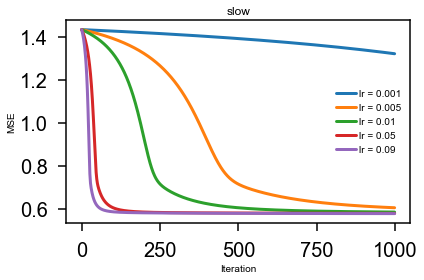

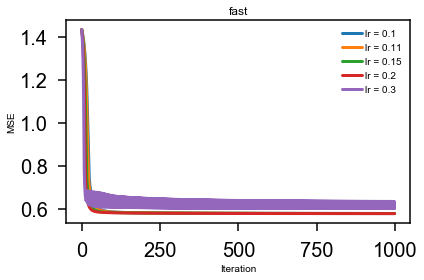

In [65]:
fast_lrs = [i for i in lrs[len(lrs)//2:]]
slow_lrs = [i for i in lrs[:len(lrs)//2]]

for lr in slow_lrs:
    plt.plot(t_losses[lr], label=f"lr = {lr}")
plt.title("slow")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()  

for lr in fast_lrs:
    plt.plot(t_losses[lr], label=f"lr = {lr}")
plt.title("fast")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()  

In [66]:
# PyTorch
t_min_array = t_lr_loss[np.where(t_lr_loss == np.min(t_lr_loss[:, 1]))[0], :]
print("learning rate | final loss")
print(t_min_array)

learning rate | final loss
[[0.2       0.5784551]]


OK, it looks like the lowest final loss is achieved by using 0.2 as a learning rate in torch and numpy.

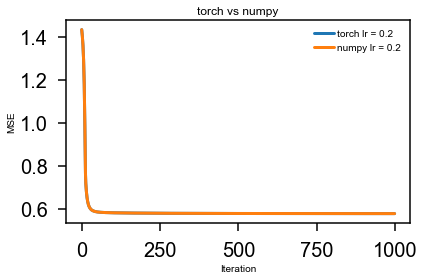

In [67]:
plt.plot(t_losses[0.2], label=f"torch lr = 0.2")
plt.plot(losses[0.2], label=f"numpy lr = 0.2")
plt.title("torch vs numpy")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()  
# They are practically identical.

In [97]:
# a parameters from torch and numpy
print(t_abvals[0.2][0])
print(abvals[0.2][0])

# b parameters from torch and numpy
print(t_abvals[0.2][1])
print(abvals[0.2][1])

def is_close(a, b, tol=1e-09):
    return abs(a-b) <= tol * max(abs(a),abs(b))

# Comparing the a and b parameters from torch and numpy using 
# the best learning rate (0.2)

# Are the a parameters basically the same?
print(is_close(t_abvals[0.2][0], abvals[0.2][0]))

# Are the b parameters basically the same?
print(np.isclose(t_abvals[0.2][1], abvals[0.2][1]).all())

# Because they are the same, the loss on the validation set will be the same

2.3101117485024862
2.3101117485024867
[[0.79052534 1.72126638 0.21791274 1.06676542 0.52851161 0.09319593]]
[[0.79052534 1.72126638 0.21791274 1.06676542 0.52851161 0.09319593]]
True
True


In [87]:
# initial values
at = torch.from_numpy(np.array([t_abvals[0.2][0]]))
bt = torch.from_numpy(t_abvals[0.2][1])
# at (1), bt (1x6)
print(at.shape, bt.shape)
xt = torch.from_numpy(xVal)
yt = torch.from_numpy(yVal)
print(xt.shape, yt.shape)

torch.Size([1]) torch.Size([1, 6])
torch.Size([20, 6]) torch.Size([20])


In [101]:
# Using these parameters in our fit function,
# what is the loss on the validation set?

# torch

at = torch.from_numpy(np.array([t_abvals[0.2][0]]))
bt = torch.from_numpy(t_abvals[0.2][1])
# at (1), bt (1x6)

xt = torch.from_numpy(xVal)
yt = torch.from_numpy(yVal)
# xt (20x6), yt (20)

ypred = at * torch.exp(-bt.matmul(xt.T))
# (1x6)dot(6x20) is (1x20)

# L2
error = yt - ypred
t_loss = (error ** 2).sum()

print(f"Loss on the validation set using torch is {t_loss.data.numpy():.3f}")

# numpy

a = abvals[0.2][0]
b = abvals[0.2][1]
# b is (1x6)

ypred = f(a, b, xVal)
# ypred is (1x20), yTrain is (20,)

# L2 loss
loss = np.sum((ypred - yVal) ** 2)

print(f"Loss on the validation set using numpy is {loss:.3f}")

# I would guess that 0.1 was the noise parameter used to generate this data set :)

Loss on the validation set using torch is 0.104
Loss on the validation set using numpy is 0.104
